In [208]:
import os
import torch
import pandas as pd
import import_ipynb
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from typing import List
import multiprocessing
import torchio as tio
import random
from pathlib import Path
from halfpipe.file_index.bids import BIDSIndex
import nibabel as nib
from nilearn.image import new_img_like, resample_img
from nilearn.plotting import plot_anat, view_img
from niworkflows.viz.utils import cuts_from_bbox, robust_set_limits
from niworkflows.utils.images import rotation2canonical, rotate_affine
from seaborn import color_palette

In [209]:
%matplotlib inline

In [210]:
def _plot_anat_with_contours(image, segs=None, **plot_params):
    nsegs = len(segs or [])
    plot_params = plot_params or {}
    # plot_params' values can be None, however they MUST NOT
    # be None for colors and levels from this point on.
    colors = plot_params.pop("colors", None) or []
    levels = plot_params.pop("levels", None) or []
    missing = nsegs - len(colors)
    if missing > 0:  # missing may be negative
        colors = colors + color_palette("husl", missing)

    colors = [[c] if not isinstance(c, list) else c for c in colors]

    if not levels:
        levels = [[0.5]] * nsegs

    # anatomical
    display = plot_anat(image, **plot_params)

    # remove plot_anat -specific parameters
    plot_params.pop("display_mode")
    plot_params.pop("cut_coords")

    plot_params["linewidths"] = 0.5
    for i in reversed(range(nsegs)):
        plot_params["colors"] = colors[i]
        display.add_contours(segs[i], levels=levels[i], **plot_params)
        
    return display

In [211]:
target_width = 2048

def to_rgb(display):
    figure = display.frame_axes.figure
    canvas = figure.canvas
    
    # scale to target_width
    width, height = canvas.get_width_height()
    figure.set_dpi(target_width / width * figure.get_dpi())
    
    canvas.draw()
    width, height = canvas.get_width_height()
    
    image = np.frombuffer(
        canvas.tostring_rgb(), dtype=np.uint8
    ).reshape((height, width, -1))[..., :3]
    
    image = image[:, :target_width, :]  # crop rounding errors
    image = image.copy()
    image.resize(height, target_width, 3)
    return image

In [212]:
def to_image(t1w_path, mask_path):
        plot_params = dict(colors=None)

        image_nii: nib.Nifti1Image = nib.load(t1w_path)
        seg_nii: nib.Nifti1Image = nib.load(mask_path)

        canonical_r = rotation2canonical(image_nii)
        image_nii = rotate_affine(image_nii, rot=canonical_r)
        seg_nii = rotate_affine(seg_nii, rot=canonical_r)

        data = image_nii.get_fdata()
        plot_params = robust_set_limits(data, plot_params)

        bbox_nii = seg_nii

        cuts = cuts_from_bbox(bbox_nii, cuts=7)

        images = list()
        for d in plot_params.pop("dimensions", ("z", "x", "y")):
            plot_params["display_mode"] = d
            plot_params["cut_coords"] = cuts[d]
            display = _plot_anat_with_contours(
                image_nii, segs=[seg_nii], **plot_params
            )
            images.append(to_rgb(display))
            display.close()

        image = np.vstack(images)
        return image

In [213]:
class SkullstripDataset(Dataset):
    """Skullstrip reports Dataset"""
    
    def __init__(self, usable_dir: Path, transform=None):
        """
        Args:
            root_dir: directory containing t1w and mask files
            transform: optional transformations on images
        """
        self.usable_dir = usable_dir
        self.transform = transform
        
        bids_idx = BIDSIndex()
        bids_idx.put(usable_dir)
        
        self.skullstrips = []
        subjects = bids_idx.get_tag_values("sub")
        for subject in subjects:
            t1w = bids_idx.get(sub=subject, suffix="T1w")
            if t1w is None:
                continue
            mask = bids_idx.get(sub=subject, suffix="mask")
            if mask is None:
                continue
            (t1w,) = t1w # 0.Element/einziges Element aus Set bekommen, da entweder None oder Set
            (mask,) = mask
            skullstrip = (t1w, mask)
            self.skullstrips.append(skullstrip)
    
    def __len__(self):
        return len(self.skullstrips)
    
    def __getitem__(self,idx):
        sample = self.skullstrips[idx]
        
        labels = ["usable", "unusable"]
        new_label = random.choice(labels)
        
        if new_label == "usable":
            transform[0](nib.load(sample[0]))
        else:
            transform[1](nib.load(sample[0]))
        
        # transforms to tensor
        # need to change axis and use transforms.Compose([transforms.ToTensor()])
        
        #t1 = nib.load(sample[0])
        #t1_data = nib.as_closest_canonical(t1).get_fdata()
        
        #mask = nib.load(sample[1])
        #mask_data = np.asanyarray(mask.dataobj)
        
        #sample[0] = transforms.ToTensor(t1_data)
        #sample[1] = transforms.ToTensor(mask_data)
        # end transforms to tensor
        image: np.ndarray = to_image(t1w_path=sample[0], mask_path=sample[1])
        image = image.transpose((2,0,1))
        #image = image.float()
        #item += new_label, # add label to tuple 
        #transforms.ToTensor(image)
        image = torch.from_numpy(image) / 255
        
        return image, new_label

In [215]:
unusable_transforms_dict = {
    tio.RandomAffine(): 1,
    tio.RandomFlip(): 1,
    tio.RandomSwap(): 1,
    tio.RandomNoise(): 1,
    tio.RandomSpike(): 1,
    tio.RandomGhosting(): 1,
    tio.RandomMotion(degrees=20, translation=20, num_transforms=3): 1,
}
unusable_transform = tio.Compose([
    tio.ToCanonical(),
    tio.OneOf(unusable_transforms_dict),
    #transforms.ToTensor(),
])


usable_transforms_dict = {
    tio.RandomGamma(): 1,
    tio.RescaleIntensity(percentiles=(2, 98)): 1,
    
}
usable_transform = tio.Compose([
    tio.ToCanonical(),
    tio.OneOf(usable_transforms_dict),
    #transforms.ToTensor(),
])
transform = [usable_transform, unusable_transform]

In [216]:
print(transform)

[Compose([ToCanonical(), OneOf()]), Compose([ToCanonical(), OneOf()])]


In [217]:
usable_directory = Path("/Users/dominik/Downloads/usable")

In [218]:
initial_dataset = SkullstripDataset(usable_dir=usable_directory, transform=transform)

dataset_size = len(initial_dataset)
train_size = int(dataset_size * 0.7)
test_size = dataset_size - train_size
lengths = [train_size, test_size]

training_set, testing_set = torch.utils.data.random_split(dataset=initial_dataset,lengths=lengths, generator=torch.Generator().manual_seed(42))

# num workers can be modified
train_loader = DataLoader(training_set.dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(testing_set.dataset, batch_size=64, num_workers=0)

torch.Size([3, 870, 2048])


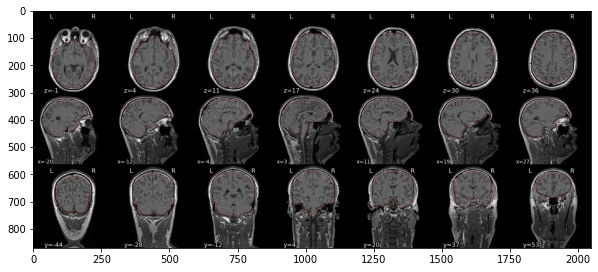

In [219]:
skullstrip_object = initial_dataset[0]
#print(skullstrip_object)
print(skullstrip_object[0].shape)
t1wpath = "/Users/dominik/Downloads/usable/ds-integrament_site-berlin_sub-PIABR9GGF_desc-preproc_T1w.nii.gz"
maskpath = "/Users/dominik/Downloads/usable/ds-integrament_site-berlin_sub-PIABR9GGF_desc-brain_mask.nii.gz"
#image = to_image(skullstrip_object[0], mask_path=skullstrip_object[1])
image = to_image(t1w_path=t1wpath, mask_path=maskpath)
#image = skullstrip_object[0]
figure = plt.figure(figsize=(10,20))
plt.imshow(image)

In [220]:
print(skullstrip_object[1])
print(skullstrip_object[0].shape)
print(type(skullstrip_object[0]))

usable
torch.Size([3, 870, 2048])
<class 'torch.Tensor'>


In [221]:
shape_ar = image
print(type(shape_ar))
print(shape_ar.shape)
new = shape_ar.transpose(2,0,1)
print(new.shape)

<class 'numpy.ndarray'>
(870, 2048, 3)
(3, 870, 2048)


In [222]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [223]:
# Skullstrip.to_image() has shape (870,2048,3) (H,W,C)

In [224]:
# Creating CNN class
import torch.nn.functional as F

class convNeuralNetwork(nn.Module):
    def __init__(self):
        super(convNeuralNetwork, self).__init__()
        
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)
        self.fc1 = nn.Linear(16*3*3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv_layer1(x)))
        x = self.pool(F.relu(self.conv_layer2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = convNeuralNetwork()

In [225]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [226]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get inputs: data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini batches
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print("Finished Training")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1762560 and 144x120)